## Coronary Heart Disease (CHD) Classification

### MLDA DLW Hackathon 2021 | Team No. \#63
<b> Done by: </b> Jonathan Edward Teo
<b> Project Aim: </b> This project aims to raise awareness of the prevalence of Coronary Heart Disease (CHD) among Singaporeans, which in turn would promote healthier living among Singaporeans.

### Classifier Goals
This classifier uses a Supervised Learning method of Random Forests to classify future instances of getting Coronary Heart Diseases and not getting Coronary Heart Disease. 

#### Datasets
For this supervised learning model, we would use datasets from four different cities in the United States:
1. The Cleveland Dataset
2. The Hungary Dataset
3. The Switzerland Dataset
4. The VA Long Beach Dataset

These datasets were created by:
1. Hungarian Institute of Cardiology - Budapest: Andras Janosi, M.D.
2. University Hospital, Zurich, Switzerland : William Steinbrunn, M.D.
3. University Hospital, Basel, Switzerland: Matthias Pfisterer, M.D.
4. V.A. Medical Center, Long Beach and Cleveland Clinic Foundation: Robert Detrano, M.D., Ph.D.

These datasets was donated by: <em> David W. Aha </em>

#### Dataset Information
These datasets consist of 76 attributes in total, but most published experiments refer to using only a subset of 14 of them. I will be doing the same by only looking at those 14 attributes, and hence I will use a _processed version_ of each of the above datasets. The above datasets were modified as follows:
- The names and social security numbers of patients were removed from the dataset, and replaced withdummy values.
- The field of diagnosis whether a patient has CHD or not is named as "Target". The unprocessed datasets classify the severity of the CHD, but in my classifier I will only be focusing on the presence of CHD (denoted as 1) and the absence of CHD (denoted as 0).

In [2]:
# Import Relevant Modules
import numpy as np
import pandas as pd

#### Loading Datasets
Each of the processed datasets has the following 14 attributes which are:
- age - Age of Patient
- sex - Sex of patient (1 = male, 0 = female) 
- cp - Value represents the type of chest pain experienced by the patient. (1 = Typical Angina, 2 = Atypical Angina, 3 = Non-anginal Pain, 4 = Asymptomatic)
- trestbps - resting blood pressure (in mm Hg on admission to the hospital)
- chol - serum cholesterol in mg / dl
- fbs - if fasting blood sugar > 120 mg/dl, then value will be 1 (for yes) and 0 (for no).
- restecg - Resting electrocardiographic results
- thalach - Maximum heart rate achieved
- exang - Exercise induced angina (1 = yes, 0 = no)
- oldpeak - ST depression induced by exercise relative to rest
- slope - the slope of the peak exercise ST segment
- ca - number of major vessels (0 - 3) coloured by flurosopy
- thal (short for thalassemia) - 3 = normal, 6 = fixed defect, 7 = reversable effect.
- Target - label for attribute ( 0 = no CHD, 1 = mild CHD, 2 = moderate CHD, 3 = severe CHD)


In [3]:
def load_data():
    ''' This function loads all the processed datasets
    and combines them into a single dataframe. 
    It also removes all entries with missing values.
    '''
    all_dataframes = list()
    for filename in ['processed_cleveland', 'processed_hungarian', 'processed_longbeach_va', 'processed_switzerland']:
        df = pd.read_csv("{}.csv".format(filename), 
                         header = None,
                        na_values = '?')
        df.dropna(inplace = True)
        df.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang', 'oldpeak', 'slope', 'ca', 'thal', 'Target']
        # Update the target column to only have either positive class (1) and negative class (0)
        df['Target'] = [1 if i > 0 else 0 for i in df['Target']]
        all_dataframes.append(df) 
    # combine all datasets into a single dataframe.    
    for dataframe in all_dataframes[1:]:
        all_dataframes[0] = all_dataframes[0].append(dataframe, ignore_index = True)
        
    return all_dataframes[0]

chd_df = load_data()
chd_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,Target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0.0


### Preprocessing of Data
#### Distribution of Data

In [8]:
def getClassDist(df):
    '''
    Accepts a pandas dataframe.
    Returns a tuple showing the class distribution in the
    (negative class, positive class) format.
    '''
    if (not isinstance(df, pd.DataFrame)):
        return 
    # Get positive class
    chd_pos = len(df[df['Target'] == 1])
    # Get negative class
    chd_neg = len(df) - chd_pos
    return (chd_neg, chd_pos)
getClassDist(chd_df)


(160, 139)

Since the class distribution is somewhat unevenly distributed, a __macro__ model evaluation metric would be used for model evaluation later. 

#### Data Visualisation

In [49]:
def plot_scatter_matrix(dataframe):
  '''
  This function accepts a dataframe, and plots a scatter matrix to highlight
  the distribution of the data. 
  
  This is just to see the pairwise relationships between the fourteen variables 
  of the dataset.
  This function returns None.
  '''
  if (not isinstance(dataframe, pd.DataFrame)):
    return
  #!pip install seaborn
  %matplotlib inline
  import matplotlib.pyplot as plt
  from matplotlib import cm
  import seaborn as sns
  cmap = cm.get_cmap('gnuplot')
  sns.pairplot(dataframe, hue = 'Target', height = 3)
  plt.show()

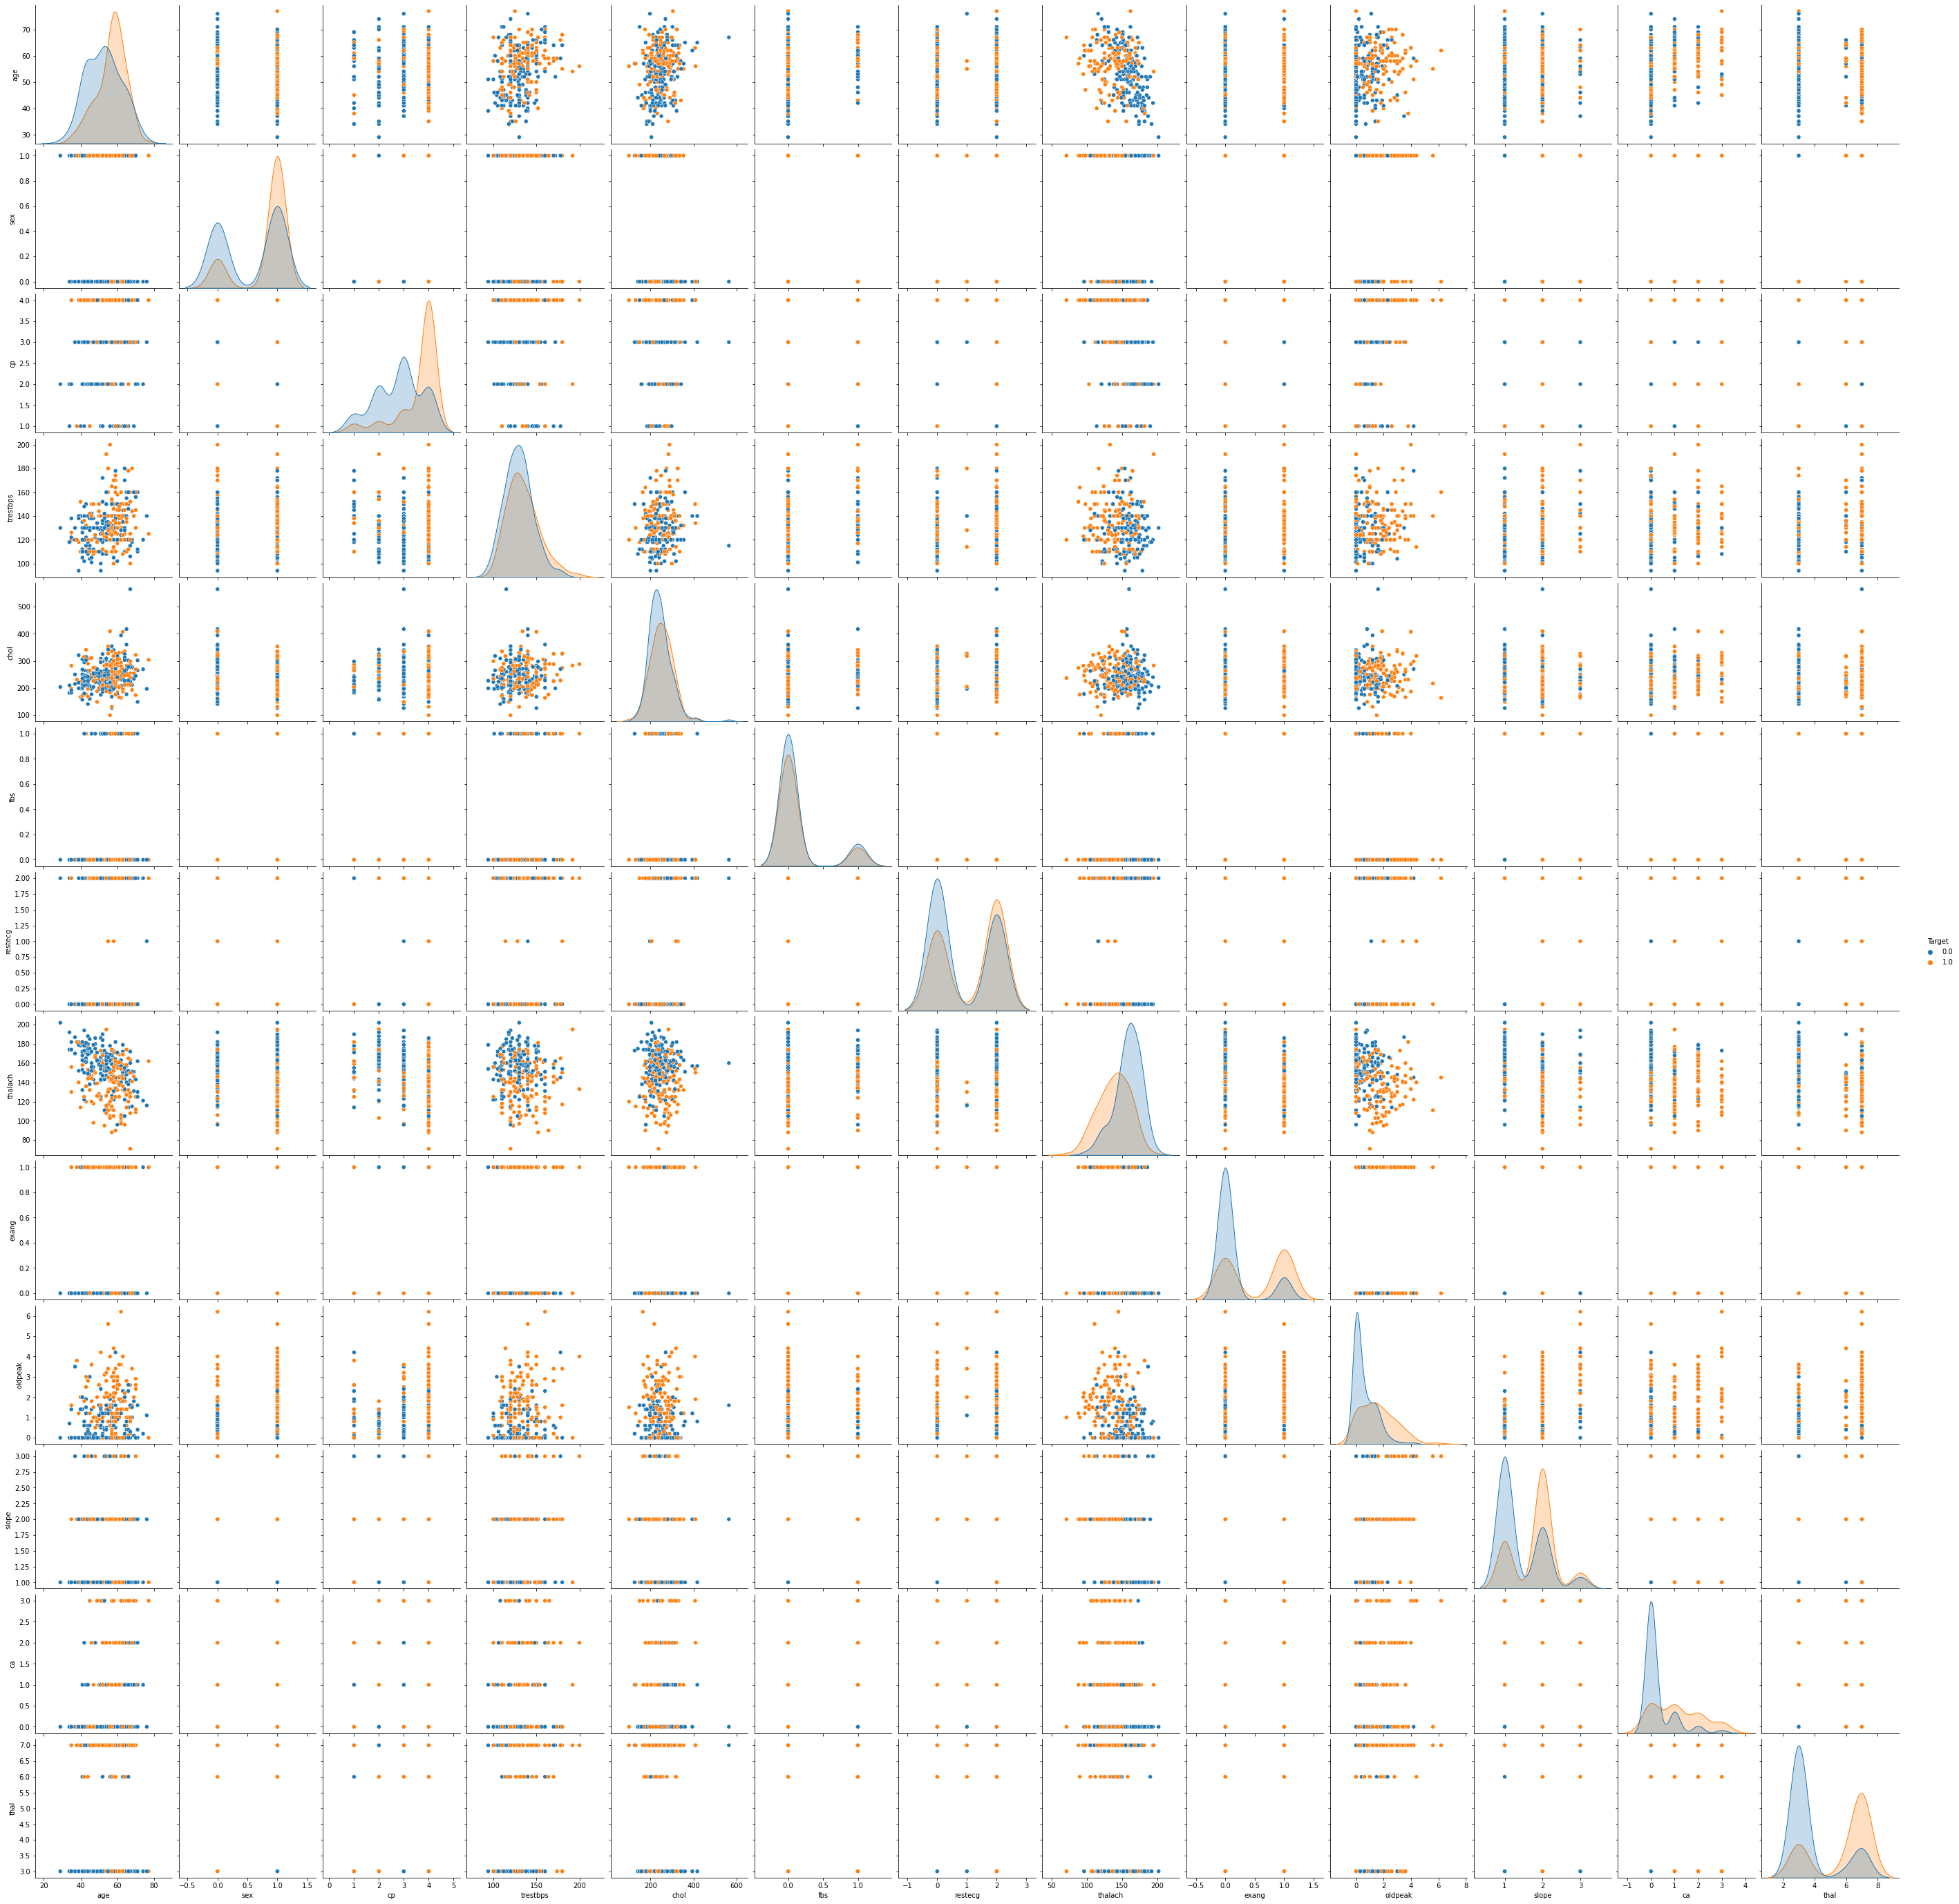

In [50]:
plot_scatter_matrix(chd_df)

#### Feature Scaling of Data
Feature scaling is typically not needed for DecisionTree classifiers. Hence the feature normalisation step here is excluded.

In [41]:
def dataset_preparation(df):
    '''
    This function accepts a pandas dataframe. 
    It returns 4 dataframes in the following order: 
    - X_train - which consists of the training set, 
    - X_test  - which consists of the testing set,
    - y_train - which consists of the target values for the training set, 
    - y_test  - which consists of the target values for the test set.
    '''
    if (not isinstance(df, pd.DataFrame)): 
        return
    from sklearn.model_selection import train_test_split
    data, target =df.drop('Target', axis = 1), df['Target']
    # In order to save the file into CoreML format, we have to encode the Target values:
    from sklearn.preprocessing import LabelEncoder
    target_encoded = LabelEncoder().fit_transform(target)
    X_train, X_test, y_train, y_test = train_test_split(data, target_encoded, 
                                                        random_state = 0)
    y_train_df = pd.DataFrame(y_train, columns = ['Target'])
    y_test_df = pd.DataFrame(y_test, columns = ['Target'])
    return tuple((X_train, X_test, y_train_df, y_test_df))

datasets = dataset_preparation(chd_df)
datasets[0].head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
258,58.0,0.0,2.0,136.0,319.0,1.0,2.0,152.0,0.0,0.0,1.0,2.0,3.0
37,57.0,1.0,4.0,150.0,276.0,0.0,2.0,112.0,1.0,0.6,2.0,1.0,6.0
97,52.0,1.0,2.0,134.0,201.0,0.0,0.0,158.0,0.0,0.8,1.0,1.0,3.0
191,68.0,0.0,3.0,120.0,211.0,0.0,2.0,115.0,0.0,1.5,2.0,0.0,3.0
135,70.0,1.0,4.0,145.0,174.0,0.0,0.0,125.0,1.0,2.6,3.0,0.0,7.0


### Training and Evaluation of model using Random Forests

#### Intuition
Since CHD is a disease with no apparent symptoms, we would like a classifier to be slightly more cautious in the prediction of Coronary Heart Disease (CHD). Hence, it is natural to aim for a minimisation of the occurence of __false negatives__. Hence, we would score our classifier in terms of __recall__. Since the classes are unevenly distributed to some extent, we would use _macro recall_ to score our classifier. 

This classifier uses a <b>Random Forest </b> classifier model, which is a more advanced version of a single Decision Tree. The Random forest is a model made up of many decision trees. This would minimise the risk of overfitting the training data, as compared to using a single Decision Tree. the bias of the dataset and its associated variance would be reduced due to the reliance of a broader group of trees (decision makers), and this would cancel out the noise if any through the random sampling of the data. 

#### Final ML Model
The final ML Model parameters was derived from a GridSearch in Scikit Learn, which has the following parameters to the RandomForest classifier:
<code>
        'max_depth': 2,
        'min_samples_leaf': 3,
        'min_samples_split': 11,
        'n_estimators': 900
</code> 
This model obtained a mean recall score of <b>0.837</b> with other metrics:
- Mean accuracy score: 0.843
- Mean Precision Score: 0.855
- Mean AUC Score: 0.918

measured across a stratified 5-fold cross-validation of the dataset used. 


Directly below is the code, and the remainder of this notebook is the derivation of the parameters of the best model.
<hr>

In [45]:
def getBestParams(data, grid_values, numFolds):
    '''
    This function takes in a tuple of four dataframes => X_train, X_test, y_train, y_test from the code above, 
    a dictionary of grid_values,
    an integer of the number of folds for cross-validation of the GridSearch method.
    Then, it searches for the best model within this predefined grid values.
    It returns a tuple of 4 items, 
    - the best parameters of the model found,
    - the  score on the training set (float) (of the best model),
    - the score on the test set (float) (of the best model), 
    - the classifier of the best model (a classifier).
    '''
    if(not isinstance(data, tuple) or not isinstance(grid_values, dict) or not isinstance(numFolds, int)):
        print("Invalid Input!")
        return
    if (not len(data) == 4):
        print("Invalid Input!")
        return
    # Create a model instance
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    # Create a data instance of the classifier.
    rf = RandomForestClassifier(random_state = 0)
    # Obtain training and test data
    X_train, X_test, y_train, y_test = data
    # y_train and y_Test are dataframes, so convert them to arrays
    y_train, y_test = y_train['Target'], y_test['Target']
    #print(X_test.shape, y_test.shape)
    # Create a model_selection object
    gridsearch = GridSearchCV(estimator = rf,
                              param_grid = grid_values,
                              scoring = 'recall_macro', 
                              n_jobs = 3,
                              cv = numFolds)
    gridsearch.fit(X_train, y_train)
    bestclf = gridsearch.best_params_
    # Create a classifier fitted with the best parameters.
    best_rf = RandomForestClassifier(max_depth = bestclf['max_depth'],
                                     min_samples_leaf = bestclf['min_samples_leaf'],
                                     min_samples_split = bestclf['min_samples_split'],
                                     n_estimators = bestclf['n_estimators'],
                                     random_state = 0).fit(X_train,y_train)
    return  (gridsearch.best_params_, gridsearch.score(X_train, y_train), gridsearch.score(X_test,y_test), best_rf)

def cross_validate(data, clf):
    '''
    This function takes in a classifier with the best parameters, along with the dataset used, 
    and cross validates with other evaluation metrics.
    This function returns None.
    '''
    from sklearn.model_selection import cross_val_score
    # Obtain training and test data
    X_train, X_test, y_train, y_test = data
    # Cross-val score in sklearn.model_selection does not require a train test split, for the sake of the function
    # I will merge my training and test data, and the stratified K-fold validation implemented within the 
    # cross-val score function will do the train test splits for me automatically. 
    X = X_train.append(X_test, ignore_index = False)
    y = y_train.append(y_test, ignore_index = False)
    # y is a dataframe, convert it to a 1D array.
    y = y['Target']
    # Calculate scores across a stratified 5 fold validation
    accuracy_scores = cross_val_score(clf, X, y, cv = 5, scoring = 'accuracy')
    precision_scores = cross_val_score(clf, X, y, cv = 5, scoring = 'precision_macro')
    recall_scores = cross_val_score(clf, X, y, cv = 5, scoring = 'recall_macro')
    AUC_scores = cross_val_score(clf, X, y, cv = 5, scoring = 'roc_auc')
    print("Accuracy score: {} | Mean Accuracy Score: {:.3f} ".format(accuracy_scores, 
                                                                 np.array(accuracy_scores).mean()))
    print("Precision (macro) score: {} | Mean Precision (Macro) Score: {:.3f}".format(precision_scores, 
                                                                                  np.array(precision_scores).mean()))
    print("Recall (Macro) score: {} | Mean Recall (Macro) Score: {:.3f} ".format(recall_scores, 
                                                                 np.array(recall_scores).mean()))
    print("AUC score: {} | Mean AUC Score: {:.3f} ".format(AUC_scores, 
                                                                 np.array(AUC_scores).mean()))

#### Best Model


In [46]:
# This is just to show the cross-validation scores. This is NOT how I derived the values XD. (See below) 
bestModelInfo = getBestParams(datasets, {'max_depth': [2], 
                                        'min_samples_leaf':[3], 
                                        'min_samples_split':[11], 
                                        'n_estimators':[900]}, 10)
print("Best Parameters: ", bestModelInfo[0])
cross_validate(datasets, bestModelInfo[3])

Best Parameters:  {'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 900}
Accuracy score: [0.83333333 0.83333333 0.81666667 0.83333333 0.89830508] | Mean Accuracy Score: 0.843 
Precision (macro) score: [0.83258929 0.83484163 0.83699634 0.8625     0.90881643] | Mean Precision (Macro) Score: 0.855
Recall (Macro) score: [0.83258929 0.83035714 0.80803571 0.82366071 0.89178241] | Mean Recall (Macro) Score: 0.837 
AUC score: [0.91852679 0.92522321 0.91741071 0.93080357 0.89699074] | Mean AUC Score: 0.918 


### Process: Finding the Best Parameters

##### Iteration No. 1
In order to prevent long compile times, I actually ran this cell a couple of times using a small grid space. To further reduce the computation costs, I initially set the stratified cross validation to __2-folds__.  
The first attempt was using the following grid_values:
<pre><code>
grid_values = {
    'max_depth': [<b>5</b>,7,9],
    'min_samples_leaf': [<b>3</b>, 4, 5],
    'min_samples_split': [8, 10, <b>12</b>],
    'n_estimators': [100, 200, <b>300</b>]
}
numFold = 2
</code></pre>
and the bolded parameters were the best parameters for the model.
CV Scores:


In [41]:
modelInfo = getBestParams(datasets, {'max_depth': [5,7,9],
                                    'min_samples_leaf': [3, 4, 5],
                                    'min_samples_split': [8, 10,12],
                                    'n_estimators': [100, 200, 300]},
                        2)
print("Best Parameters: ", modelInfo[0])
cross_validate(datasets, modelInfo[3])

Best Parameters:  {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100}
Accuracy score: [0.83333333 0.8        0.81666667 0.85       0.88135593] | Mean Accuracy Score: 0.836 
Precision (macro) score: [0.83333333 0.79910714 0.83699634 0.87362637 0.88690476] | Mean Precision (Macro) Score: 0.846
Recall (Macro) score: [0.83482143 0.79910714 0.80803571 0.84151786 0.87615741] | Mean Recall (Macro) Score: 0.832 
AUC score: [0.9140625  0.92522321 0.90178571 0.93526786 0.90046296] | Mean AUC Score: 0.915 


##### Iteration No. 2
I manually adjust these grid values, for instance on the second time running the gridsearch, I used the following parameters instead.
<pre><code>
grid_values = {
    'max_depth': [<b>3</b>,4,5],
    'min_samples_leaf': [1,2,<b>3</b>],
    'min_samples_split': [<b>12</b>,20],
    'n_estimators': [300, <b>1000</b>]
}
numFold = 2
</code></pre>
and the bolded parameters were the best for my model.

In [42]:
modelInfo = getBestParams(datasets,  {'max_depth': [3,4,5],
                                    'min_samples_leaf': [1,2,3],
                                    'min_samples_split': [12,20],
                                    'n_estimators': [300,1000]},
                          2)
print("Best Parameters: ", modelInfo[0])
cross_validate(datasets, modelInfo[3])

Best Parameters:  {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 1000}
Accuracy score: [0.85       0.81666667 0.81666667 0.83333333 0.91525424] | Mean Accuracy Score: 0.846 
Precision (macro) score: [0.84927697 0.81649832 0.83699634 0.8625     0.92202381] | Mean Precision (Macro) Score: 0.857
Recall (Macro) score: [0.85044643 0.81473214 0.80803571 0.82366071 0.91030093] | Mean Recall (Macro) Score: 0.841 
AUC score: [0.91294643 0.92410714 0.9140625  0.93415179 0.90162037] | Mean AUC Score: 0.917 


##### Iteration No. 3
<pre><code>
    grid_values = {
        'max_depth': [<b>2</b>,3,4],
        'min_samples_leaf': [3],
        'min_samples_split': [<b>12</b>,15],
        'n_estimators': [<b>1000</b>, 2000, 3000]
    }
    numFold = 2
</code></pre>
and the bolded parameters were the best for my model.

In [43]:
modelInfo = getBestParams(datasets,  {'max_depth': [2,3,4],
                                    'min_samples_leaf': [3],
                                    'min_samples_split': [12,15],
                                    'n_estimators': [1000, 2000, 3000]},
                          2)
print("Best Parameters: ", modelInfo[0])
cross_validate(datasets, modelInfo[3])

Best Parameters:  {'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 12, 'n_estimators': 1000}
Accuracy score: [0.83333333 0.83333333 0.81666667 0.83333333 0.89830508] | Mean Accuracy Score: 0.843 
Precision (macro) score: [0.83258929 0.83484163 0.83699634 0.8625     0.90881643] | Mean Precision (Macro) Score: 0.855
Recall (Macro) score: [0.83258929 0.83035714 0.80803571 0.82366071 0.89178241] | Mean Recall (Macro) Score: 0.837 
AUC score: [0.91741071 0.92410714 0.91741071 0.9296875  0.89583333] | Mean AUC Score: 0.917 


#####  Iteration No. 4
This is the last iteration with the following parameters:
<pre><code>
    grid_values = {
        'max_depth': [<b>2</b>,3,4],
        'min_samples_leaf': [<b>3</b>],
        'min_samples_split': [<b>11</b>,12,13],
        'n_estimators': [<b>900</b>, 1000, 1100]
    }
    numFold = <b>10</b>
</code></pre>
and the bolded parameters were the best for my model. This is how I obtained the values that I derived earlier.

In [44]:
modelInfo = getBestParams(datasets,  {'max_depth': [2,3,4],
                                    'min_samples_leaf': [3],
                                    'min_samples_split': [11,12,13],
                                    'n_estimators': [900, 1000, 1100]},
                          10)
print("Best Parameters: ", modelInfo[0])
cross_validate(datasets, modelInfo[3])

Best Parameters:  {'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 11, 'n_estimators': 900}
Accuracy score: [0.83333333 0.83333333 0.81666667 0.83333333 0.89830508] | Mean Accuracy Score: 0.843 
Precision (macro) score: [0.83258929 0.83484163 0.83699634 0.8625     0.90881643] | Mean Precision (Macro) Score: 0.855
Recall (Macro) score: [0.83258929 0.83035714 0.80803571 0.82366071 0.89178241] | Mean Recall (Macro) Score: 0.837 
AUC score: [0.91852679 0.92522321 0.91741071 0.93080357 0.89699074] | Mean AUC Score: 0.918 


### Limitations of the Approach
There are cons associated with this approach: 
1) It is less intuitive as compared to a single decision tree, and it is harder to derive how and why a classifier arrived at a conclusion.

2) In fact, there are more robust versions of the CHD detection out there in the web. This research journal 
<a>https://www.hindawi.com/journals/cin/2021/8387680/</a> obtained an accuracy of 94.2% accuracy using Deep Learning and outlier detection using Isolation using Feature Selection. 

### Saving The Model

In [52]:
def save_model(clf, input_features, output_feature):
    #!pip install --force-reinstall scikit-learn==0.19.2
    import coremltools
    model = coremltools.converters.sklearn.convert(clf, input_features, output_feature)
    model.save("CHD_Model.mlmodel")
    
save_model(bestModelInfo[3],
           ["age","sex","cp","trestbps","chol","fbs","restecg","thalach","exang","oldpeak","slope","ca","thal"],
           "Target")